In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
import math
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import numba
from numba import jit, int32, int64, float32, float64

In [2]:
#iris = sns.load_dataset('iris')

# matrix data
#X = np.array(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
#specs = np.array(iris['species'])

In [3]:
X = np.loadtxt("Data/mnist2500_X.txt")
labels = np.loadtxt("Data/mnist2500_labels.txt")
small = X[:50]
small.shape

(50, 784)

## Original Code

In [4]:
def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows.
    Output is a pairwise distance matrix D that is nxn.
    """
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
    return D


def p_cond(d_matrix, sigmas):
    """Convert a distances matrix to a matrix of conditional probabilities."""

    sig_2 = np.square(sigmas.reshape((-1, 1)))
    P_cond = np.exp((d_matrix / (2 * sig_2)) - np.max((d_matrix / (2 * sig_2)), axis=1).reshape([-1, 1]))

    # set p_i|i = 0
    np.fill_diagonal(P_cond, 0.)

    P_cond = (P_cond + 1e-10) / (P_cond + 1e-10).sum(axis=1).reshape([-1, 1])

    return P_cond


def binary_search(eval_fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.
    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        mid = (lower + upper) / 2.
        val = eval_fn(mid)
        if val > target:
            upper = mid
        else:
            lower = mid
        if np.abs(val - target) <= tol:
            break
    return mid


def perp(d_matrix, sigmas):
    """calculate perplexity from distance matrix, sigmas, and conditional probability matrix."""
    P = p_cond(d_matrix, sigmas)
    entropy = -np.sum(P * np.log2(P), axis=1)
    perplexity = 2 ** entropy

    return perplexity


def find_optimal_sigmas(d_matrix, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = []
    # For each row of the matrix (each point in our dataset)
    for i in range(d_matrix.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perp(d_matrix[i:i + 1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)


def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""

    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)

    # q_i|i = 0
    np.fill_diagonal(Q, 0.)

    return Q


def p_ij(X, target_perplexity):
    """Calculate joint probabilities in the high dimensional space given data matrix X
    and a target perplexity to find optimal sigmas (pg. 2584).
    """

    d_matrix = -squared_euc_dist(X)

    # optimal sigma for each row of distance matrix
    sigmas = find_optimal_sigmas(d_matrix, target_perplexity)

    # conditional p matrix from optimal sigmas
    p_conditional = p_cond(d_matrix, sigmas)

    # convert conditional P to joint P matrix (pg. 2584)
    n = p_conditional.shape[0]
    p_joint = (p_conditional + p_conditional.T) / (2. * n)

    return p_joint


def grad_C(P, Q, Y):
    """Calculate gradient of cost function (KL) with respect to lower dimensional map points Y (pg. 2586)"""

    pq_diff = (P - Q)[:, :, np.newaxis]

    y_diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]

    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))[:, :, np.newaxis]

    grad = 4. * (pq_diff * y_diff * y_dist).sum(axis=1)

    return grad


def tsne(X, num_iters=1000, perplexity=30, alpha=10, momentum=0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    Inputs:
        X: data matrix
        num_iters: number of iterations
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm
    """

    # Initialize Y
    Y = (np.random.RandomState(1)).normal(0., 0.0001, [X.shape[0], 2])

    P = p_ij(X, perplexity)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):
        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - alpha * grad) + (momentum * (Y_tmin1 - Y_tmin2))

        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y


yout = tsne(small)

In [5]:
%timeit -r3 -n3 tsne(X[:50, ])

normal = %timeit -o -r3 -n3 tsne(X[:50, ])

362 ms ± 10.7 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
348 ms ± 3.36 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


Text(0.5, 1.0, 'Original Code on 50 values of MNIST')

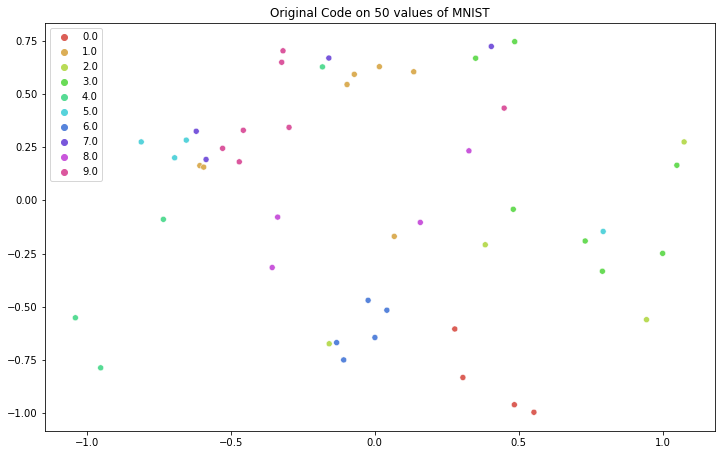

In [6]:
plt.figure(figsize=(12,7.5))
plot = sns.scatterplot(x = yout[:,0], y = yout[:,1], hue = labels[:50], palette = sns.hls_palette(10), legend = 'full');
plt.title('Original Code on 50 values of MNIST')

## Reformed and added numba JIT

In [7]:
@jit(nopython = True)
def p_ij(d_matrix, perplexity = 30.0, tol = 1e-5):
    """
    Finds P_ij matrix using binary search to find value of sigma_i

    Inputs: X- np.array of pairwise distance matrix, fixed perplexity

    Output: P-ij matrix
    """
    steps = 10 # maximum number of binary search steps

    (n, d) = d_matrix.shape

    P = np.zeros((n, d), dtype=np.float64)
    beta_sum = 0.0
    log_perp = np.log(perplexity)

    for i in range(n):
        beta_min = -np.inf
        beta_max = np.inf
        beta = 1.0

        # Binary search of precision for i-th conditional distribution
        for j in range(steps):
            sum_Pi = 0.0
            for k in range(d):
                if k != i:
                    P[i, k] = math.exp(-d_matrix[i, k] * beta)
                    sum_Pi += P[i, k]

            sum_disti_Pi = 0.0

            for k in range(d):
                P[i, k] /= sum_Pi
                sum_disti_Pi += d_matrix[i, k] * P[i, k]

            entropy = np.log(sum_Pi) + beta * sum_disti_Pi
            entropy_diff = entropy - log_perp

            if math.fabs(entropy_diff) <= tol:
                break

            if entropy_diff > 0.0:
                beta_min = beta
                if beta_max == np.inf:
                    beta *= 2.0
                else:
                    beta = (beta + beta_max) / 2.0
            else:
                beta_max = beta
                if beta_min == -np.inf:
                    beta /= 2.0
                else:
                    beta = (beta + beta_min) / 2.0

        beta_sum += beta

    return P



# this works alone
@jit(nopython = True)
def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    
    return D

@jit(nopython = True)
def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""
    
    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)
    
    # q_i|i = 0
    np.fill_diagonal(Q, 0.)
    
    return Q

# THIS WORKS
@jit(nopython = True)
def grad_C(P, Q, Y):
    """Estimate the gradient of t-SNE cost with respect to Y."""
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_distances = np.power(1 + squared_euc_dist(Y), -1)

    # Expand our inv_distances matrix so can multiply by y_diffs
    distances_expanded = np.expand_dims(inv_distances, 2)

    # Multiply this by inverse distances matrix
    y_diffs_wt = y_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad


@jit(nopython = True)
def tsne_opt(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    
    Inputs: 
        X: data matrix 
        num_iters: number of iterations 
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm 
    """

    # Initialize Y 
    np.random.seed(0)
    Y = np.random.normal(0, 0.0001, size=(X.shape[0], 2))
    D = squared_euc_dist(X)
    P = p_ij(D)
    P = P + np.transpose(P)
    P = P / np.sum(P)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):

        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - (alpha * grad)) +  (momentum * (Y_tmin1 - Y_tmin2))
  
        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y

yout2 = tsne_opt(small)

In [8]:
%timeit -r3 -n3 tsne_opt(X[:50, ])

numb = %timeit -o -r3 -n3 tsne_opt(X[:50, ])

76.4 ms ± 4.52 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
79.4 ms ± 530 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


Text(0.5, 1.0, 'JIT Code on 50 values of MNIST')

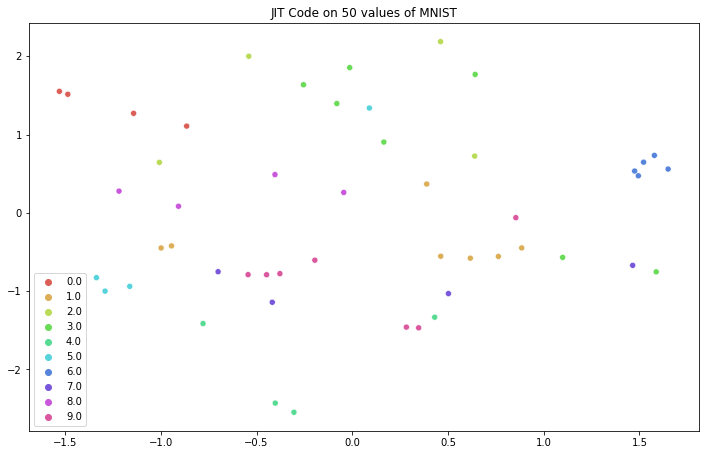

In [9]:
plt.figure(figsize=(12,7.5))
plot = sns.scatterplot(x = yout2[:,0], y = yout2[:,1], hue = labels[:50], palette = sns.hls_palette(10), legend = 'full');
plt.title('JIT Code on 50 values of MNIST')

## Cythonize

In [10]:
%load_ext cython

In [11]:
%%cython -a

from libc cimport math
cimport cython
import numpy as np
cimport numpy as np
from numpy cimport ndarray


@cython.boundscheck(False)
@cython.wraparound(False)
def p_ij_cy(double[:,:] d_matrix, float perplexity = 30.0, float tol = 1e-5):
    """
    Finds P_ij matrix using binary search to find value of sigma_i

    Inputs: X- np.array of pairwise distance matrix, fixed perplexity

    Output: P-ij matrix
    """
    cdef int steps = 10 # maximum number of binary search steps
    
    cdef int n = d_matrix.shape[0], d = d_matrix.shape[1]
    
    cdef np.ndarray[np.float64_t, ndim=2] P = np.zeros(
        (n,d), dtype=np.float64)

    cdef float beta_sum = 0.0
    log_perp = np.log(perplexity)

    for i in range(n):
        beta_min = -np.inf
        beta_max = np.inf
        beta = 1.0

        # Binary search of precision for i-th conditional distribution
        for j in range(steps):
            sum_Pi = 0.0
            for k in range(d):
                if k != i:
                    P[i, k] = math.exp(-d_matrix[i, k] * beta)
                    sum_Pi += P[i, k]

            sum_disti_Pi = 0.0

            for k in range(d):
                P[i, k] /= sum_Pi
                sum_disti_Pi += d_matrix[i, k] * P[i, k]

            entropy = np.log(sum_Pi) + beta * sum_disti_Pi
            entropy_diff = entropy - log_perp

            if math.fabs(entropy_diff) <= tol:
                break

            if entropy_diff > 0.0:
                beta_min = beta
                if beta_max == np.inf:
                    beta *= 2.0
                else:
                    beta = (beta + beta_max) / 2.0
            else:
                beta_max = beta
                if beta_min == -np.inf:
                    beta /= 2.0
                else:
                    beta = (beta + beta_min) / 2.0

        beta_sum += beta

    return P


In [12]:
# this works alone

def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    
    return D


def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""
    
    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)
    
    # q_i|i = 0
    np.fill_diagonal(Q, 0.)
    
    return Q


def grad_C(P, Q, Y):
    """Estimate the gradient of t-SNE cost with respect to Y."""
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_distances = np.power(1 + squared_euc_dist(Y), -1)

    # Expand our inv_distances matrix so can multiply by y_diffs
    distances_expanded = np.expand_dims(inv_distances, 2)

    # Multiply this by inverse distances matrix
    y_diffs_wt = y_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad


def tsne_opt2(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    
    Inputs: 
        X: data matrix 
        num_iters: number of iterations 
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm 
    """

    # Initialize Y 
    np.random.seed(0)
    Y = np.random.normal(0, 0.0001, size=(X.shape[0], 2))
    D = squared_euc_dist(X)
    P = p_ij_cy(D)
    P = P + np.transpose(P)
    P = P / np.sum(P)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):

        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - (alpha * grad)) +  (momentum * (Y_tmin1 - Y_tmin2))
  
        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y

yout3 = tsne_opt2(small)

Text(0.5, 1.0, 'Cython Code on 50 values of MNIST')

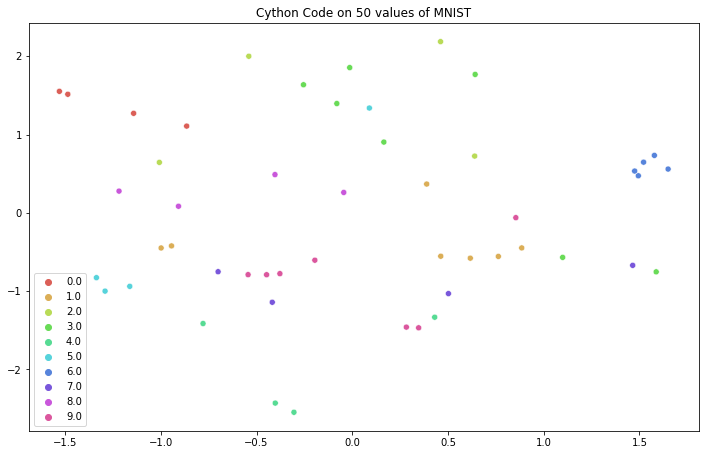

In [13]:
plt.figure(figsize=(12,7.5))
plot = sns.scatterplot(x = yout3[:,0], y = yout3[:,1], hue = labels[:50], palette = sns.hls_palette(10), legend = 'full');
plt.title('Cython Code on 50 values of MNIST')

In [14]:
%timeit -r3 -n3 tsne_opt(X[:50, ])

cy = %timeit -o -r3 -n3 tsne_opt(X[:50, ])

80.4 ms ± 1.98 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
76.2 ms ± 1.4 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [16]:
# speed up multiplier

types = [numb, cy]
mult = list(map(lambda x: (normal.average/x.average), types))

import pandas as pd

pd.DataFrame(mult, index = ['Numba', 'Cython'], columns = ["Speed-up Multiplier"])

,Speed-up Multiplier
Numba,4.378975
Cython,4.560254
